## Personalized Learning (Localized Learning?)

#### This notebook includes the following online models;
1. A single global model with all data
2. Multiple local models (starting from a single global model)
   1. that are updated with new data
   2. that exchanges data in clusters
   3. that exchanges parameters in clusters

  
#### The dataset that is used for this project is [CIFAR-100 dataset][1]
* Has 100 classes containing 600 images each

#### New data are fed by the following rules;
1. Distributed, according to superclasses
  * Clusters will only be updated with data that belongs to a specific superclass
  * We update the NN by
    1. Changing all parameters of the NN
    2. Only changing the last few layers, as in many MTL models
2. Randomly (why?)

#### We expect to find an answer to the following research questions with this project;
1. If models are updated with data (or parameters) that are shared within a cluster, can the model perform good enough with the labels that count?
  * For example, the performance of the cluster that are updated with "Vehicles" superclass is only assessed with the labels that corresponds to the superclass.
  
[1]: https://www.cs.toronto.edu/~kriz/cifar.html

#### Questions

Retraining: how does it work <br>
How do we compare these models?


### Implementation with Custom Neural Network and EMNIST dataset

In [1]:
%load_ext tensorboard

In [2]:
from __future__ import print_function
import tensorflow.keras as keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import backend as K

In [3]:
import matplotlib

In [4]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines

In [5]:
import tensorflow as tf
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [6]:
tf.__version__

'1.15.2'

In [7]:
# Hyperparameters
batch_size = 50
epochs = 20

# input image dimensions
img_rows, img_cols = 28, 28

#### Load MNIST dataset

In [8]:
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [9]:
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [10]:
x_train.shape

(60000, 28, 28, 1)

In [11]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [12]:
global_dataset_size = 6000
local_dataset_size = 40000

In [13]:
X_global = x_train[-global_dataset_size:]
Y_global = y_train[-global_dataset_size:]
X_local = x_train[:-global_dataset_size]
Y_local = y_train[:-global_dataset_size]

In [14]:
len(np.unique(y_train))

10

In [15]:
import utils

In [16]:
import importlib
importlib.reload(utils)

<module 'utils' from '/home/seth/projects/fed-learn-experiment/utils.py'>

In [25]:
X_local_list, Y_local_list = utils.split_training_set(4000, 10, X_local, Y_local)

In [28]:
X_local_list[8].shape

(4154, 28, 28, 1)

In [29]:
# convert class vectors to binary class matrices
num_classes = 10
Y_global = keras.utils.to_categorical(Y_global, num_classes)

In [30]:
y_test = keras.utils.to_categorical(y_test, num_classes)

In [31]:
x_test.shape

(10000, 28, 28, 1)

### Define models and compile & fit function

In [32]:
def custom_model():
    model = Sequential()
    model.add(Flatten(input_shape=input_shape))
    model.add(Dense(200, activation='relu'))
    model.add(Dense(200, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    return model

In [33]:
def compile_model(model):  
    # initiate SGD optimizer
    opt = keras.optimizers.SGD(lr=0.1)
    model.compile(loss='mean_squared_error', optimizer=opt, metrics=['accuracy'])

In [34]:
def compile_model_lr(model):  
    # initiate SGD optimizer
    opt = keras.optimizers.SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='mean_squared_error', optimizer=opt, metrics=['accuracy'])

In [35]:
def fit_model_global(model, epochs):
    now = datetime.datetime.now()
    print ("Training date and time : ")
    print (now.strftime("%Y-%m-%d %H:%M:%S"))
    return model.fit(X_global, Y_global,
                      batch_size=100,
                      epochs=40,
                      shuffle=True, callbacks=[tensorboard_callback])

In [36]:
def fit_model_with_datasets(model, epochs, x_train, y_train):
    now = datetime.datetime.now()
    print ("Training date and time : ")
    print (now.strftime("%Y-%m-%d %H:%M:%S"))
    return model.fit(x_train, y_train,
                      batch_size=batch_size,
                      epochs=epochs,
                      shuffle=True, validation_split=0.1, verbose=1)

In [37]:
model1 = custom_model()
compile_model(model1)
fit_model_with_datasets(model1, 30, X_global, Y_global)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Training date and time : 
2020-05-18 10:32:59
Train on 5400 samples, validate on 600 samples
Epoch 1/30
5400/5400 [==============================] - 1s 94us/sample - loss: 0.0882 - acc: 0.2176 - val_loss: 0.0859 - val_acc: 0.3600
Epoch 2/30
5400/5400 [==============================] - 0s 35us/sample - loss: 0.0838 - acc: 0.3628 - val_loss: 0.0806 - val_acc: 0.4250
Epoch 3/30
5400/5400 [==============================] - 0s 35us/sample - loss: 0.0782 - acc: 0.4670 - val_loss: 0.0738 - val_acc: 0.4967
Epoch 4/30
5400/5400 [==============================] - 0s 30us/sample - loss: 0.0711 - acc: 0.5467 - val_loss: 0.0654 - val_acc: 0.5650
Epoch 5/30
5400/5400 [==============================] - 0s 29us/sample - loss: 0.0625 - acc: 0.6291 - val_loss: 0.0561 - val_acc: 0.6850
Epoch 6/30
5400/5400 [==============================] - 0s 32us/sample - loss: 0.0533 - acc: 0.7167 - val_loss: 0.0469 - val_acc: 0.7533
Epoc

In [38]:
model_list = list()
for _ in range(15):
    model_list.append(tf.keras.models.clone_model(model1)) 
    model_list[_].set_weights(model1.get_weights())

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [39]:
standard_model = tf.keras.models.clone_model(model1)
standard_model.set_weights(model1.get_weights())

In [40]:
import semantic_drift

In [41]:
importlib.reload(semantic_drift)

<module 'semantic_drift' from '/home/seth/projects/fed-learn-experiment/semantic_drift.py'>

### Conduct transfer learning in local models using different datasets & epochs


In [42]:
for i in range(len(model_list)):
    compile_model(model_list[i])
    fit_model_with_datasets(model_list[i], (i+1)*10, X_local_list[0], Y_local_list[0])

Training date and time : 
2020-05-18 10:33:37
Train on 3738 samples, validate on 416 samples
Epoch 1/10
3738/3738 [==============================] - 0s 58us/sample - loss: 0.0159 - acc: 0.8994 - val_loss: 0.0132 - val_acc: 0.9255
Epoch 2/10
3738/3738 [==============================] - 0s 36us/sample - loss: 0.0154 - acc: 0.9037 - val_loss: 0.0133 - val_acc: 0.9231
Epoch 3/10
3738/3738 [==============================] - 0s 36us/sample - loss: 0.0149 - acc: 0.9053 - val_loss: 0.0130 - val_acc: 0.9303
Epoch 4/10
3738/3738 [==============================] - 0s 38us/sample - loss: 0.0145 - acc: 0.9098 - val_loss: 0.0129 - val_acc: 0.9279
Epoch 5/10
3738/3738 [==============================] - 0s 38us/sample - loss: 0.0142 - acc: 0.9141 - val_loss: 0.0128 - val_acc: 0.9303
Epoch 6/10
3738/3738 [==============================] - 0s 37us/sample - loss: 0.0139 - acc: 0.9168 - val_loss: 0.0128 - val_acc: 0.9351
Epoch 7/10
3738/3738 [==============================] - 0s 37us/sample - loss: 0.0136

3738/3738 [==============================] - 0s 30us/sample - loss: 0.0117 - acc: 0.9312 - val_loss: 0.0119 - val_acc: 0.9423
Epoch 17/50
3738/3738 [==============================] - 0s 30us/sample - loss: 0.0115 - acc: 0.9329 - val_loss: 0.0118 - val_acc: 0.9375
Epoch 18/50
3738/3738 [==============================] - 0s 29us/sample - loss: 0.0113 - acc: 0.9334 - val_loss: 0.0119 - val_acc: 0.9447
Epoch 19/50
3738/3738 [==============================] - 0s 29us/sample - loss: 0.0112 - acc: 0.9329 - val_loss: 0.0117 - val_acc: 0.9351
Epoch 20/50
3738/3738 [==============================] - 0s 29us/sample - loss: 0.0111 - acc: 0.9355 - val_loss: 0.0115 - val_acc: 0.9375
Epoch 21/50
3738/3738 [==============================] - 0s 31us/sample - loss: 0.0109 - acc: 0.9361 - val_loss: 0.0116 - val_acc: 0.9375
Epoch 22/50
3738/3738 [==============================] - 0s 29us/sample - loss: 0.0108 - acc: 0.9387 - val_loss: 0.0114 - val_acc: 0.9375
Epoch 23/50
3738/3738 [=======================

Epoch 25/60
3738/3738 [==============================] - 0s 31us/sample - loss: 0.0104 - acc: 0.9417 - val_loss: 0.0114 - val_acc: 0.9375
Epoch 26/60
3738/3738 [==============================] - 0s 27us/sample - loss: 0.0102 - acc: 0.9419 - val_loss: 0.0114 - val_acc: 0.9375
Epoch 27/60
3738/3738 [==============================] - 0s 30us/sample - loss: 0.0101 - acc: 0.9411 - val_loss: 0.0111 - val_acc: 0.9423
Epoch 28/60
3738/3738 [==============================] - 0s 31us/sample - loss: 0.0100 - acc: 0.9438 - val_loss: 0.0111 - val_acc: 0.9399
Epoch 29/60
3738/3738 [==============================] - 0s 35us/sample - loss: 0.0099 - acc: 0.9422 - val_loss: 0.0112 - val_acc: 0.9375
Epoch 30/60
3738/3738 [==============================] - 0s 39us/sample - loss: 0.0098 - acc: 0.9449 - val_loss: 0.0112 - val_acc: 0.9375
Epoch 31/60
3738/3738 [==============================] - 0s 42us/sample - loss: 0.0097 - acc: 0.9465 - val_loss: 0.0111 - val_acc: 0.9375
Epoch 32/60
3738/3738 [===========

Epoch 24/70
3738/3738 [==============================] - 0s 33us/sample - loss: 0.0105 - acc: 0.9401 - val_loss: 0.0113 - val_acc: 0.9375
Epoch 25/70
3738/3738 [==============================] - 0s 32us/sample - loss: 0.0104 - acc: 0.9382 - val_loss: 0.0112 - val_acc: 0.9399
Epoch 26/70
3738/3738 [==============================] - 0s 32us/sample - loss: 0.0103 - acc: 0.9395 - val_loss: 0.0113 - val_acc: 0.9375
Epoch 27/70
3738/3738 [==============================] - 0s 32us/sample - loss: 0.0101 - acc: 0.9419 - val_loss: 0.0113 - val_acc: 0.9375
Epoch 28/70
3738/3738 [==============================] - 0s 33us/sample - loss: 0.0100 - acc: 0.9441 - val_loss: 0.0111 - val_acc: 0.9399
Epoch 29/70
3738/3738 [==============================] - 0s 33us/sample - loss: 0.0099 - acc: 0.9436 - val_loss: 0.0111 - val_acc: 0.9375
Epoch 30/70
3738/3738 [==============================] - 0s 33us/sample - loss: 0.0098 - acc: 0.9457 - val_loss: 0.0113 - val_acc: 0.9375
Epoch 31/70
3738/3738 [===========

Epoch 13/80
3738/3738 [==============================] - 0s 30us/sample - loss: 0.0122 - acc: 0.9259 - val_loss: 0.0123 - val_acc: 0.9423
Epoch 14/80
3738/3738 [==============================] - 0s 30us/sample - loss: 0.0120 - acc: 0.9291 - val_loss: 0.0119 - val_acc: 0.9327
Epoch 15/80
3738/3738 [==============================] - 0s 31us/sample - loss: 0.0119 - acc: 0.9288 - val_loss: 0.0120 - val_acc: 0.9351
Epoch 16/80
3738/3738 [==============================] - 0s 29us/sample - loss: 0.0117 - acc: 0.9326 - val_loss: 0.0118 - val_acc: 0.9423
Epoch 17/80
3738/3738 [==============================] - 0s 30us/sample - loss: 0.0115 - acc: 0.9323 - val_loss: 0.0118 - val_acc: 0.9399
Epoch 18/80
3738/3738 [==============================] - 0s 31us/sample - loss: 0.0114 - acc: 0.9326 - val_loss: 0.0118 - val_acc: 0.9399
Epoch 19/80
3738/3738 [==============================] - 0s 31us/sample - loss: 0.0112 - acc: 0.9358 - val_loss: 0.0118 - val_acc: 0.9375
Epoch 20/80
3738/3738 [===========

Epoch 51/90
3738/3738 [==============================] - 0s 33us/sample - loss: 0.0079 - acc: 0.9580 - val_loss: 0.0106 - val_acc: 0.9399
Epoch 52/90
3738/3738 [==============================] - 0s 32us/sample - loss: 0.0079 - acc: 0.9583 - val_loss: 0.0105 - val_acc: 0.9423
Epoch 53/90
3738/3738 [==============================] - 0s 33us/sample - loss: 0.0078 - acc: 0.9599 - val_loss: 0.0108 - val_acc: 0.9399
Epoch 54/90
3738/3738 [==============================] - 0s 34us/sample - loss: 0.0077 - acc: 0.9599 - val_loss: 0.0105 - val_acc: 0.9423
Epoch 55/90
3738/3738 [==============================] - 0s 33us/sample - loss: 0.0077 - acc: 0.9601 - val_loss: 0.0107 - val_acc: 0.9399
Epoch 56/90
3738/3738 [==============================] - 0s 32us/sample - loss: 0.0076 - acc: 0.9601 - val_loss: 0.0105 - val_acc: 0.9423
Epoch 57/90
3738/3738 [==============================] - 0s 33us/sample - loss: 0.0075 - acc: 0.9601 - val_loss: 0.0106 - val_acc: 0.9423
Epoch 58/90
3738/3738 [===========

3738/3738 [==============================] - 0s 32us/sample - loss: 0.0063 - acc: 0.9674 - val_loss: 0.0104 - val_acc: 0.9447
Epoch 79/100
3738/3738 [==============================] - 0s 32us/sample - loss: 0.0063 - acc: 0.9679 - val_loss: 0.0104 - val_acc: 0.9399
Epoch 80/100
3738/3738 [==============================] - 0s 32us/sample - loss: 0.0062 - acc: 0.9682 - val_loss: 0.0104 - val_acc: 0.9399
Epoch 81/100
3738/3738 [==============================] - 0s 32us/sample - loss: 0.0062 - acc: 0.9695 - val_loss: 0.0104 - val_acc: 0.9399
Epoch 82/100
3738/3738 [==============================] - 0s 32us/sample - loss: 0.0061 - acc: 0.9682 - val_loss: 0.0104 - val_acc: 0.9399
Epoch 83/100
3738/3738 [==============================] - 0s 32us/sample - loss: 0.0061 - acc: 0.9690 - val_loss: 0.0104 - val_acc: 0.9399
Epoch 84/100
3738/3738 [==============================] - 0s 32us/sample - loss: 0.0060 - acc: 0.9695 - val_loss: 0.0103 - val_acc: 0.9423
Epoch 85/100
3738/3738 [================

3738/3738 [==============================] - 0s 32us/sample - loss: 0.0056 - acc: 0.9716 - val_loss: 0.0103 - val_acc: 0.9399
Epoch 96/110
3738/3738 [==============================] - 0s 32us/sample - loss: 0.0055 - acc: 0.9722 - val_loss: 0.0103 - val_acc: 0.9399
Epoch 97/110
3738/3738 [==============================] - 0s 32us/sample - loss: 0.0055 - acc: 0.9727 - val_loss: 0.0104 - val_acc: 0.9423
Epoch 98/110
3738/3738 [==============================] - 0s 33us/sample - loss: 0.0055 - acc: 0.9735 - val_loss: 0.0102 - val_acc: 0.9447
Epoch 99/110
3738/3738 [==============================] - 0s 33us/sample - loss: 0.0054 - acc: 0.9735 - val_loss: 0.0102 - val_acc: 0.9447
Epoch 100/110
3738/3738 [==============================] - 0s 34us/sample - loss: 0.0054 - acc: 0.9732 - val_loss: 0.0101 - val_acc: 0.9447
Epoch 101/110
3738/3738 [==============================] - 0s 33us/sample - loss: 0.0054 - acc: 0.9741 - val_loss: 0.0102 - val_acc: 0.9399
Epoch 102/110
3738/3738 [=============

3738/3738 [==============================] - 0s 32us/sample - loss: 0.0053 - acc: 0.9741 - val_loss: 0.0103 - val_acc: 0.9423
Epoch 103/120
3738/3738 [==============================] - 0s 31us/sample - loss: 0.0053 - acc: 0.9741 - val_loss: 0.0102 - val_acc: 0.9447
Epoch 104/120
3738/3738 [==============================] - 0s 31us/sample - loss: 0.0053 - acc: 0.9743 - val_loss: 0.0105 - val_acc: 0.9399
Epoch 105/120
3738/3738 [==============================] - 0s 31us/sample - loss: 0.0052 - acc: 0.9743 - val_loss: 0.0102 - val_acc: 0.9399
Epoch 106/120
3738/3738 [==============================] - 0s 32us/sample - loss: 0.0052 - acc: 0.9746 - val_loss: 0.0101 - val_acc: 0.9423
Epoch 107/120
3738/3738 [==============================] - 0s 32us/sample - loss: 0.0052 - acc: 0.9749 - val_loss: 0.0102 - val_acc: 0.9423
Epoch 108/120
3738/3738 [==============================] - 0s 32us/sample - loss: 0.0051 - acc: 0.9743 - val_loss: 0.0101 - val_acc: 0.9423
Epoch 109/120
3738/3738 [=========

3738/3738 [==============================] - 0s 37us/sample - loss: 0.0054 - acc: 0.9743 - val_loss: 0.0103 - val_acc: 0.9399
Epoch 100/130
3738/3738 [==============================] - 0s 37us/sample - loss: 0.0054 - acc: 0.9730 - val_loss: 0.0102 - val_acc: 0.9447
Epoch 101/130
3738/3738 [==============================] - 0s 38us/sample - loss: 0.0054 - acc: 0.9730 - val_loss: 0.0102 - val_acc: 0.9447
Epoch 102/130
3738/3738 [==============================] - 0s 36us/sample - loss: 0.0053 - acc: 0.9741 - val_loss: 0.0101 - val_acc: 0.9447
Epoch 103/130
3738/3738 [==============================] - 0s 38us/sample - loss: 0.0053 - acc: 0.9741 - val_loss: 0.0102 - val_acc: 0.9423
Epoch 104/130
3738/3738 [==============================] - 0s 39us/sample - loss: 0.0053 - acc: 0.9749 - val_loss: 0.0102 - val_acc: 0.9399
Epoch 105/130
3738/3738 [==============================] - 0s 37us/sample - loss: 0.0052 - acc: 0.9746 - val_loss: 0.0102 - val_acc: 0.9423
Epoch 106/130
3738/3738 [=========

3738/3738 [==============================] - 0s 34us/sample - loss: 0.0059 - acc: 0.9703 - val_loss: 0.0104 - val_acc: 0.9399
Epoch 87/140
3738/3738 [==============================] - 0s 34us/sample - loss: 0.0059 - acc: 0.9698 - val_loss: 0.0102 - val_acc: 0.9447
Epoch 88/140
3738/3738 [==============================] - 0s 32us/sample - loss: 0.0058 - acc: 0.9708 - val_loss: 0.0102 - val_acc: 0.9399
Epoch 89/140
3738/3738 [==============================] - 0s 33us/sample - loss: 0.0058 - acc: 0.9700 - val_loss: 0.0103 - val_acc: 0.9447
Epoch 90/140
3738/3738 [==============================] - 0s 34us/sample - loss: 0.0058 - acc: 0.9703 - val_loss: 0.0103 - val_acc: 0.9447
Epoch 91/140
3738/3738 [==============================] - 0s 34us/sample - loss: 0.0057 - acc: 0.9708 - val_loss: 0.0103 - val_acc: 0.9447
Epoch 92/140
3738/3738 [==============================] - 0s 34us/sample - loss: 0.0057 - acc: 0.9711 - val_loss: 0.0102 - val_acc: 0.9447
Epoch 93/140
3738/3738 [================

3738/3738 [==============================] - 0s 37us/sample - loss: 0.0072 - acc: 0.9620 - val_loss: 0.0104 - val_acc: 0.9399
Epoch 64/150
3738/3738 [==============================] - 0s 38us/sample - loss: 0.0071 - acc: 0.9636 - val_loss: 0.0105 - val_acc: 0.9423
Epoch 65/150
3738/3738 [==============================] - 0s 38us/sample - loss: 0.0070 - acc: 0.9633 - val_loss: 0.0105 - val_acc: 0.9447
Epoch 66/150
3738/3738 [==============================] - 0s 36us/sample - loss: 0.0070 - acc: 0.9647 - val_loss: 0.0105 - val_acc: 0.9447
Epoch 67/150
3738/3738 [==============================] - 0s 39us/sample - loss: 0.0069 - acc: 0.9650 - val_loss: 0.0104 - val_acc: 0.9447
Epoch 68/150
3738/3738 [==============================] - 0s 38us/sample - loss: 0.0069 - acc: 0.9650 - val_loss: 0.0104 - val_acc: 0.9447
Epoch 69/150
3738/3738 [==============================] - 0s 40us/sample - loss: 0.0068 - acc: 0.9666 - val_loss: 0.0104 - val_acc: 0.9423
Epoch 70/150
3738/3738 [================

Epoch 122/150
3738/3738 [==============================] - 0s 34us/sample - loss: 0.0047 - acc: 0.9770 - val_loss: 0.0099 - val_acc: 0.9423
Epoch 123/150
3738/3738 [==============================] - 0s 35us/sample - loss: 0.0047 - acc: 0.9773 - val_loss: 0.0099 - val_acc: 0.9399
Epoch 124/150
3738/3738 [==============================] - 0s 34us/sample - loss: 0.0047 - acc: 0.9770 - val_loss: 0.0099 - val_acc: 0.9399
Epoch 125/150
3738/3738 [==============================] - 0s 32us/sample - loss: 0.0046 - acc: 0.9778 - val_loss: 0.0099 - val_acc: 0.9399
Epoch 126/150
3738/3738 [==============================] - 0s 33us/sample - loss: 0.0046 - acc: 0.9778 - val_loss: 0.0098 - val_acc: 0.9423
Epoch 127/150
3738/3738 [==============================] - 0s 34us/sample - loss: 0.0046 - acc: 0.9783 - val_loss: 0.0099 - val_acc: 0.9423
Epoch 128/150
3738/3738 [==============================] - 0s 34us/sample - loss: 0.0046 - acc: 0.9775 - val_loss: 0.0099 - val_acc: 0.9423
Epoch 129/150
3738/3

### Let's see how these models are different from each other, compared to the base model(before training)


In [43]:
dists = [semantic_drift.l2_distance(standard_model, m) for m in model_list]
print(dists)

[0.49092203, 0.8314665, 1.1135027, 1.3575116, 1.574934, 1.7718439, 1.9546021, 2.1236625, 2.2770913, 2.4207997, 2.5532637, 2.674287, 2.786849, 2.892571, 2.9939706]


In [44]:
np.arange(5, (len(dists)+2)*5, 5)

array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80])

In [45]:
np.abs(-2)

2

In [46]:
def model_combs(model_list, model_dists):
    combs = list()
    dists = list()
    l = len(model_list)
    for i in range(l):
        for j in range(l):
            if i > j:
                combs.append([model_list[i], model_list[j]])
                dists.append(np.abs(model_dists[i]-model_dists[j]))
    combs_sorted = [x for _,x in sorted(zip(dists, combs))]
    return combs_sorted, sorted(dists)

### The l2-distance increases in respect to epochs

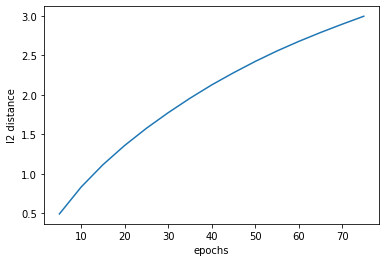

In [47]:
import matplotlib.pyplot as plt
plt.plot(np.arange(5, (len(dists)+1)*5, 5), np.array(dists))
plt.ylabel("l2 distance")
plt.xlabel("epochs")
plt.show()

### Get model combinations

In [48]:
combs, model_dists = model_combs(model_list, dists)

In [49]:
theta_list = [0, 0.6, 1]
agg_weights_list_per_pi = list()
cross_dists = list()

for comb in combs:
    weights = [comb[0].get_weights(), comb[1].get_weights()]
    agg_weights_list = list()
    for theta in theta_list:
        agg_weights = list()
        for weights_list_tuple in zip(*weights):
            agg_weights.append(np.array([np.average(np.array(w), axis=0, weights=[1. - theta, theta]) for w in zip(*weights_list_tuple)]))
        agg_weights_list.append(agg_weights)
    cross_dists.append(semantic_drift.l2_distance(comb[0], comb[1]))
    agg_weights_list_per_pi.append(agg_weights_list)

In [50]:
B = np.zeros(len(agg_weights_list_per_pi))

i = 0
for agg_weights_list in agg_weights_list_per_pi:

    aggr_model = keras.models.clone_model(model1)
    aggr_model.set_weights(agg_weights_list[1])
    compile_model(aggr_model)
    score = aggr_model.evaluate(x=x_test, y=y_test, verbose=0)

    aggr_model = keras.models.clone_model(model1)
    aggr_model.set_weights(agg_weights_list[0])
    compile_model(aggr_model)
    comp_score1 = aggr_model.evaluate(x=x_test, y=y_test, verbose=0)

    aggr_model = keras.models.clone_model(model1)
    aggr_model.set_weights(agg_weights_list[2])
    compile_model(aggr_model)
    comp_score2 = aggr_model.evaluate(x=x_test, y=y_test, verbose=0)

    B[i] = min(comp_score1[0], comp_score2[0]) - score[0]
    K.clear_session() #prevent memory leak https://github.com/keras-team/keras/issues/13118
    i += 1
    if i % 10 == 0:
        print("{}th iteration".format(i))

10th iteration
20th iteration
30th iteration
40th iteration
50th iteration
60th iteration
70th iteration
80th iteration
90th iteration
100th iteration


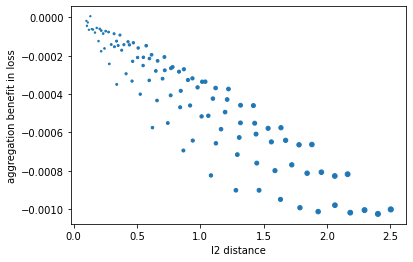

In [51]:
plt.scatter(np.array(model_dists), np.array(B), s=np.array(cross_dists)*10)
plt.ylabel("aggregation benefit in loss")
plt.xlabel("l2 distance")
plt.show()

In [53]:
ws = combs[0][0].get_weights()

ValueError: Fetch argument <tf.Variable 'dense_17/kernel:0' shape=(784, 200) dtype=float32> cannot be interpreted as a Tensor. (Tensor Tensor("dense_17/kernel/Read/ReadVariableOp:0", shape=(784, 200), dtype=float32) is not an element of this graph.)

### Change THETA_AS_VARIABLE to true to get a 3D graph

In [130]:
THETA_AS_VARIABLE = False

In [131]:
if not THETA_AS_VARIABLE:
    theta_list = [0, 0.6, 1]
    agg_weights_list_per_pi = list()
    dist_list = list()

    for model in model_list:
        weights = [model1.get_weights(), model.get_weights()]
        agg_weights_list = list()
        for theta in theta_list:
            agg_weights = list()
            for weights_list_tuple in zip(*weights):
                agg_weights.append(np.array([np.average(np.array(w), axis=0, weights=[1. - theta, theta]) for w in zip(*weights_list_tuple)]))
            agg_weights_list.append(agg_weights)
        dist_list.append(semantic_drift.l2_distance(model1, model))
        agg_weights_list_per_pi.append(agg_weights_list)

In [132]:
if THETA_AS_VARIABLE:
    theta_list = list(np.arange(0, 1.05, 0.05))
    agg_weights_list_per_pi = list()    # \pi for perturbations
    dist_list = list()
    for model in model_list:
        weights = [model1.get_weights(), model.get_weights()]
        agg_weights_list = list()
        for theta in theta_list:
            agg_weights = list()
            for weights_list_tuple in zip(*weights):
                agg_weights.append(np.array([np.average(np.array(w), axis=0, weights=[1. - theta, theta]) for w in zip(*weights_list_tuple)]))
            agg_weights_list.append(agg_weights)
        dist_list.append(semantic_drift.l2_distance(model1, model))
        agg_weights_list_per_pi.append(agg_weights_list)

In [133]:
len(dist_list)

40

In [134]:
if not (np.diff(dist_list)>0).all():
    print("The dist list does not monotonically increase!")

In [135]:
if not THETA_AS_VARIABLE:
    B = np.zeros(len(agg_weights_list_per_pi))

    i = 0
    for agg_weights_list in agg_weights_list_per_pi:

        aggr_model = keras.models.clone_model(model1)
        aggr_model.set_weights(agg_weights_list[1])
        compile_model(aggr_model)
        score = aggr_model.evaluate(x=x_test, y=y_test, verbose=0)
        
        aggr_model = keras.models.clone_model(model1)
        aggr_model.set_weights(agg_weights_list[0])
        compile_model(aggr_model)
        comp_score1 = aggr_model.evaluate(x=x_test, y=y_test, verbose=0)
        
        aggr_model = keras.models.clone_model(model1)
        aggr_model.set_weights(agg_weights_list[2])
        compile_model(aggr_model)
        comp_score2 = aggr_model.evaluate(x=x_test, y=y_test, verbose=0)
        
        B[i] = score[0] - min(comp_score1[0], comp_score2[0])
        K.clear_session() #prevent memory leak https://github.com/keras-team/keras/issues/13118
        i += 1
        if i % 10 == 0:
            print("{}th iteration".format(i))

10th iteration
20th iteration
30th iteration
40th iteration


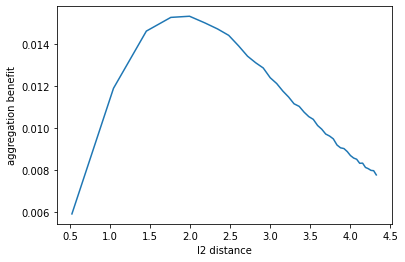

In [136]:
epoch_list = np.arange(5, (len(dist_list)+1)*5, 5)
if not THETA_AS_VARIABLE:
    plt.plot(np.array(dist_list), np.array(B))
    plt.ylabel("aggregation benefit")
    plt.xlabel("l2 distance")
    plt.show()

In [93]:
if THETA_AS_VARIABLE:
    X, Y = np.meshgrid(np.array(theta_list), np.array(dist_list))
    Z = np.zeros(X.shape)
    i = 0
    for agg_weights_list in agg_weights_list_per_pi:
        j = 0
        for agg_weights in agg_weights_list:
            aggr_model = keras.models.clone_model(model1)
            aggr_model.set_weights(agg_weights)
            compile_model(aggr_model)
            score = aggr_model.evaluate(x=x_test, y=y_test, verbose=0)
            Z[i][j] = score[0]
            j += 1
            K.clear_session() #prevent memory leak https://github.com/keras-team/keras/issues/13118
        i += 1
        print("{}th iteration".format(i))

1th iteration
2th iteration
3th iteration
4th iteration
5th iteration
6th iteration
7th iteration
8th iteration
9th iteration
10th iteration
11th iteration
12th iteration
13th iteration
14th iteration
15th iteration
16th iteration
17th iteration
18th iteration
19th iteration
20th iteration


In [94]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

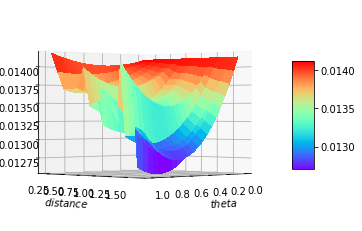

In [98]:
if THETA_AS_VARIABLE:
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    surf = ax.plot_surface(X, Y, Z, cmap=cm.rainbow,
                           linewidth=0, antialiased=False)
    ax.set_xlabel('$theta$')
    ax.set_ylabel('$distance$')
    ax.set_zlabel('$loss$')
    # Customize the z axis.
    # ax.set_xlim(0.051, 0.054)
    # ax.zaxis.set_major_locator(LinearLocator(10))
    # ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
    ax.view_init(0, 45)
    # ax.view_init(0, 0)
    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.savefig('fig1.png')
    plt.show()